# Maximiser la marge en Deep Learning : Une exploration du *Large Margin Loss*

# Sommaire

### 1. **Introduction et Contexte**

### 2. **Rappels théoriques avancés**

### 3. **Implémentation et Expérimentations**

### 4. **Applications et Extensions**

### 5. **Conclusion**


# 1. Introduction et contexte

L'objectif de ce notebook est de présenter les *Large Margin Deep Networks* pour la classification, en explorant leur efficacité et leurs avantages par rapport aux méthodes classiques. Nous nous concentrerons sur l'intégration de la notion de marge dans les réseaux neuronaux profonds, un domaine qui a émergé comme une approche prometteuse pour améliorer la généralisation des modèles dans les tâches de classification (Elsayed et al., 2018).

Les réseaux neuronaux profonds ont montré des performances exceptionnelles dans divers domaines de la classification, comme la vision par ordinateur et la reconnaissance de la parole. Cependant, ils sont souvent sensibles au surapprentissage, en particulier lorsqu'ils sont entraînés sur des données complexes ou déséquilibrées. L'une des solutions classiques à ce problème est l'introduction de la notion de *marge*, qui a fait ses preuves dans des méthodes comme les machines à vecteurs de support (SVM).

La question ici est : *Comment intégrer efficacement la notion de marge dans les réseaux neuronaux profonds pour améliorer leur capacité à généraliser sur des données non vues, tout en maintenant une performance élevée ?*

Les marges, qui font référence à la distance entre les frontières de décision et les exemples de données, sont connues pour améliorer la robustesse des modèles en réduisant la variance et en évitant le surapprentissage. Cependant, dans le cadre des réseaux neuronaux profonds, il devient difficile de maintenir des marges larges sans sacrifier la flexibilité du modèle. Les *Large Margin Deep Networks* (LMDN) proposent une extension des techniques à marge, en cherchant à exploiter ces marges dans des architectures profondes tout en conservant leur capacité à apprendre des représentations complexes.

## 2. Aspects théoriques  

Dans un classifieur linéaire comme le *SVM*, la marge est définie comme la distance entre un échantillon et l’hyperplan séparateur. Cette notion repose sur une frontière de décision plane et fixe, facilitant l’optimisation et l’interprétation (Vapnik, 1995). Cependant, dans un réseau de neurones profond (*DNN*), la frontière de décision est issue d’une composition non linéaire de transformations paramétriques, rendant la notion de marge plus complexe à formaliser et optimiser.  

### 2.1 La frontière de décision est une surface non linéaire complexe  

Dans un réseau neuronal à $L$ couches avec des poids $W^{(l)}$ et des fonctions d’activation $\sigma^{(l)}$, la sortie du modèle s’écrit comme une composition :  

$$
f(x) = W^{(L)} \sigma^{(L-1)}( W^{(L-1)} \dots \sigma^{(1)}(W^{(1)} x + b^{(1)}) \dots + b^{(L-1)}) + b^{(L)}
$$

La frontière de décision est donnée par l’ensemble des points où $f(x) = 0$ dans le cas d'un problème de classification binaire. Pour un problème de classification multiclasse, la condition à appliquer est $f_i(x) = f_j(x)$, avec $f_i(x)$ (respectivement $f_j(x)$) la sortie du réseau de neurones pour la classe $i$ de l'exemple $x$, donc la $i$-ième (respectivement $j$-ième) composante du vecteur $f(x)$.

Contrairement aux *SVM*, où la frontière est un hyperplan défini par une équation linéaire, ici, elle est une surface hautement non linéaire et dépend des transformations successives. Cette non-linéarité rend la notion de *distance* entre un point et la frontière significativement plus difficile à calculer analytiquement.

Formellement, la marge associée à un réseau neuronal dépend du point considérée, et peut être définie comme la plus petite perturbation  $\delta$ nécessaire pour modifier la classification du modèle, soit :

$$
\gamma(x) = \min_{\|\delta\| \leq \epsilon} \|\delta\| \quad \text{tel que} \quad \arg\max_j f_j(x) \neq \arg\max_j f_j(x + \delta)
$$

où :
- $\delta$ est une petite perturbation appliquée à $x$ ;
- $\epsilon$ représente une borne supérieure sur la perturbation $\delta$, qui sert à contrôler la "taille" des modifications autorisées dans l'entrée $x$ avant que la classe prédite par le modèle ne change.

### 2.2 La distance aux frontières de décision varie fortement selon les régions de l’espace  

Le concept de marge prend en compte l'espace dans lequel celle-ci est considérée. Dans un*SVM*linéaire, la marge optimale est uniforme dans l’espace d’entrée, garantissant une séparation constante entre les classes. Dans un*SVM*à noyau, cette marge est uniforme dans l’espace transformé mais non nécessairement dans l’espace d’origine. En revanche, dans un*DNN*, la frontière de décision est non linéaire et sa courbure locale peut varier significativement, rendant la notion de marge non uniforme et dépendante des caractéristiques locales de l’espace (Bartlett et al., 2017 ; Novak et al., 2018).

Un moyen de quantifier cette variabilité est d’étudier la norme de la jacobienne du réseau :

$$
J_f(x) = \frac{\partial f}{\partial x}
$$

Lorsque $\| J_f(x) \|$ est élevée, une petite perturbation de $x$ peut déplacer sa classification, indiquant une faible marge locale. Sokolic et al. (2017) montrent que la généralisation des *DNN* dépend fortement de cette norme jacobienne, contrairement aux *SVM* où la notion de marge est plus stable dans l’ensemble de l’espace d’entrée.  

### 2.3 La profondeur du réseau influence la complexité de la marge  

Bartlett et al. (2017) montrent que la capacité d’un réseau profond à bien généraliser est liée à un concept élargi de *marge normalisée*, qui dépend de la norme des poids à travers les couches. Cette *marge normalisée* est définie comme :

$$
\gamma_{\text{norm}} = \frac{\gamma_{\text{eff}}}{\sum_{l=1}^{L} \| W^{(l)} \|}
$$

où :
- $\sum_{l=1}^{L} \| W^{(l)} \|$ est la somme des normes des poids des différentes couches du réseau, qui reflète la complexité de la transformation non linéaire.
- $\gamma_{\text{eff}}$ correspond à la *marge effective* dans l’espace des représentations neuronales, définie comme :

$$
\gamma_{\text{eff}} = \min_{i} \frac{f_{y_i}(x_i) - \max_{j \neq y_i} f_j(x_i)}{\| J_f(x_i) \|}
$$

où :
- $f_{y_i}(x_i)$ est la sortie du réseau pour la classe correcte $y_i$ ;
- $\max_{j \neq y_i} f_j(x_i)$ est la sortie la plus élevée parmi les classes incorrectes.

Ils proposent alors la borne suivante sur l'erreur de généralisation :

$$
R(f) \leq O\left(\frac{\sum_{l=1}^{L} \| W^{(l)} \|}{\gamma}\right) = O\left(\frac{1}{\gamma_{\text{norm}}}\right)
$$

L’idée principale derrière la *marge normalisée* est que plus les poids du réseau sont grands, plus une même séparation en sortie est fragile, car les petites perturbations des entrées peuvent entraîner des variations importantes des activations intermédiaires. En d’autres termes, si un réseau peut maintenir une séparation des classes tout en ayant des poids relativement petits, il est moins sujet à l’overfitting et généralise mieux.

Cette borne met en évidence un compromis fondamental : **maximiser la marge seule n’est pas suffisant**, il faut aussi contrôler la croissance des poids pour assurer une bonne généralisation. La maximisation de la marge effective ne se limite donc pas à l’écart entre classes dans l’espace de sortie, mais intègre aussi la **stabilité du modèle**. Une frontière de décision trop sensible aux variations d’entrée (grande norme de $J_f(x)$) réduit la marge effective, expliquant pourquoi un réseau peut mal généraliser malgré une bonne séparation en sortie.

### 2.4 Une approche alternative : maximiser la marge via une fonction de perte adaptée  

Face aux difficultés de définition d’une marge explicite dans les réseaux neuronaux profonds, une approche consiste à reformuler la fonction de perte pour encourager une séparation plus large entre classes. Elsayed et al. (2018) proposent ainsi une *Large Margin Loss*, qui pénalise les décisions situées trop près de la frontière en introduisant un terme contraignant la séparation dans l’espace des représentations apprises.  

Plutôt que de chercher à maximiser directement une distance géométrique, leur approche ajuste la dynamique d’apprentissage de manière à favoriser une structuration plus discriminante des données au sein du réseau. Cette méthode s’inscrit dans une tendance plus large visant à intégrer la notion de marge dans l’optimisation des réseaux neuronaux, à l’instar des travaux sur la *large-margin softmax* (Liu et al., 2016) ou la *triplet loss* (Schroff et al., 2015). Ces techniques cherchent à imposer une contrainte de séparation explicite, même si elles ne garantissent pas une marge bien définie comme dans les *SVM*.  

Intéressons-nous à cette large margin loss. Considérons un problème de classification avec $n$ classes, où chaque entrée $x$ est classifiée selon la fonction de décision $f_i(x)$ qui assigne un score à chaque classe $i$. La prédiction finale est obtenue par :  

$$
i^* = \arg\max_{i} f_i(x)
$$

La frontière de décision entre deux classes $i$ et $j$ est alors définie par l’ensemble des points où leurs scores sont égaux :  

$$
D_{i,j} = \{ x \mid f_i(x) = f_j(x) \}
$$

La marge d’un point $x$ par rapport à la frontière de décision entre $i$ et $j$ est alors définie comme la plus petite perturbation nécessaire pour changer la classe prédite :  

$$
d_{f, x, \{i,j\}} = \min_{\delta} \|\delta\|_p \quad \text{sous la contrainte} \quad f_i(x + \delta) = f_j(x + \delta)
$$

où $\|\cdot\|_p$ est une norme $l_p$ (avec $p \geq 1$).

### 2.5 Définition de la *Large Margin Loss*  

L’objectif est d’entraîner le modèle pour garantir qu’un point $x_k$ appartenant à la classe $y_k$ soit classé avec une marge d’au moins $\gamma$ vis-à-vis de toutes les autres classes $i \neq y_k$.  

Cela signifie que la différence entre les scores du modèle pour la classe correcte $y_k$ et toute autre classe $i$ doit être supérieure à $\gamma$ :

$$
f_{y_k}(x_k) - f_i(x_k) \geq \gamma, \quad \forall i \neq y_k.
$$

où $\gamma$ est un hyperparamètre qui contrôle la marge minimale souhaitée entre la classe correcte et les autres classes.

- Si cette condition est satisfaite, alors $x_k$ est bien séparé et aucune pénalité n’est appliquée.  
- Si $x_k$ est trop proche de la frontière ou mal classé (**$f_i(x_k) > f_{y_k}(x_k)$** pour au moins une classe $i \neq y_k$), alors la fonction de perte pénalise cet écart en forçant le modèle à augmenter la séparation.  

Pour cela, Elsayed et al. (2018) définissent la *Large Margin Loss* comme :

$$
\max \left( 0, \gamma + d_{f, x_k, \{i, y_k\}} \cdot \text{sign} (f_i(x_k) - f_{y_k}(x_k)) \right)
$$

où $d_{f, x_k, \{i, y_k\}}$ est la distance de $x_k$ à la frontière entre $i$ et $y_k$.  

En agrégeant cette loss sur toutes les classes $i \neq y_k$ via une fonction d’agrégation $A$ (ex. **max** ou **somme**), on obtient la **fonction de coût globale** :  

$$
L = \sum_k A_{i \neq y_k} \max \left( 0, \gamma + d_{f, x_k, \{i, y_k\}} \cdot \text{sign} (f_i(x_k) - f_{y_k}(x_k)) \right)
$$

Calculer exactement $d_{f, x, \{i,j\}}$ est intractable pour des modèles profonds non linéaires. Elsayed et al. utilisent donc une **approximation de premier ordre** via une linéarisation locale :  

$$
\tilde{d}_{f, x, \{i,j\}} = \frac{|f_i(x) - f_j(x)|}{\|\nabla_x f_i(x) - \nabla_x f_j(x) \|_q}
$$

où $q$ est la norme duale de $p$ ($l_1 \leftrightarrow l_{\infty}$, $l_2 \leftrightarrow l_2$, $l_{\infty} \leftrightarrow l_1$).

L’un des aspects clés de cette loss est qu’elle ne se limite pas à l’espace d’entrée ou de sortie, mais peut être imposée à **toutes les couches cachées**. Pour une représentation cachée $h^l$ à la couche $l$, la loss devient :  

$$
L = \sum_{l, k} A_{i \neq y_k} \max \left( 0, \gamma_l + \frac{f_i(x_k) - f_{y_k}(x_k)}{\varepsilon + \|\nabla_{h^l} f_i(x_k) - \nabla_{h^l} f_{y_k}(x_k) \|_q} \right)
$$

où :
- $\gamma_l$ définit la marge minimale souhaitée à la l-ième couche ;
- $\epsilon$ un paramètre (de faible valeur, comme $10^{-6}$) pour éviter les problèmes numériques.

Chaque couche du *DNN* ajoute donc un hyperparamètre. Pour réduire le nombre d'hyperparamètres et éviter d'introduire un biais par couche, Elsayed et al. propose d'assigner la même valeur pour chaque $\gamma_l$ pour leurs expérimentations sur la performance de cette nouvelle fonction loss (évoquées infra). Celle-ci se simplifie donc en :

$$
L = \sum_{l, k} A_{i \neq y_k} \max \left( 0, \gamma + \frac{f_i(x_k) - f_{y_k}(x_k)}{\varepsilon + \|\nabla_{h^l} f_i(x_k) - \nabla_{h^l} f_{y_k}(x_k) \|_q} \right)
$$

## 3. Implémentation et Expérimentations  

### 3.1 Contexte

Elsayed et al. proposent une comparaison des performances de la *Large Margin Loss* à celles de la *Cross-Entropy Loss* et de la *Hinge Loss* sur les données  de *MNIST*, *CIFAR-10* et *ImageNet* à travers plusieurs expérimentations portant sur trois aspects : la généralisation, la robustesse aux labels bruités et la résistance aux attaques adversariales. Ils observent alors les résultats suivants :
- meilleure séparation des classes : la *Large Margin Loss* permet d’obtenir des frontières de décision plus robustes, améliorant ainsi la classification ;
- tolérance aux labels bruités : elle résiste mieux aux erreurs d’annotation et conserve une bonne précision même lorsque les labels sont fortement perturbés ;
- meilleure généralisation : elle est plus efficace que les pertes classiques lorsque l'entraînement se fait sur un nombre réduit d'exemples ;
- robustesse aux attaques adversariales : elle offre une protection accrue contre les perturbations artificielles conçues pour tromper le modèle.

Ces résultats démontrent donc que la *Large Margin Loss* favorise une meilleure généralisation et une plus grande robustesse aux perturbations. Nous allons, pour notre part, nous concentrer sur deux autres aspects : l'influence de $\gamma$ sur les performances ; l'influence de la profondeur du réseau utilisé. Nous testons l'influence de $\gamma$ en 5 valeurs : $0.1$, $0.5$, $1.0$, $2.0$ et $5.0$. Concernant l'influence de la profondeur du réseau utilisé, nous considérons 3 structures différentes : 1 couches de 512 neurones, 3 couches de respectivement 512, 256 et 128 neurones, 6 couches de respectivmeent 1024, 512, 256, 128, 64 et 32 couches.


--- Entraînement avec gamma = 0.1 ---
Epoch 1/10 - Loss: 0.0045 - Test Accuracy: 0.9512
Epoch 2/10 - Loss: 0.0014 - Test Accuracy: 0.9635
Epoch 3/10 - Loss: 0.0011 - Test Accuracy: 0.9654
Epoch 4/10 - Loss: 0.0009 - Test Accuracy: 0.9711
Epoch 5/10 - Loss: 0.0009 - Test Accuracy: 0.9744
Epoch 6/10 - Loss: 0.0007 - Test Accuracy: 0.9728
Epoch 7/10 - Loss: 0.0006 - Test Accuracy: 0.9781
Epoch 8/10 - Loss: 0.0005 - Test Accuracy: 0.9761
Epoch 9/10 - Loss: 0.0005 - Test Accuracy: 0.9769
Epoch 10/10 - Loss: 0.0005 - Test Accuracy: 0.9759

--- Entraînement avec gamma = 0.5 ---
Epoch 1/10 - Loss: 0.0138 - Test Accuracy: 0.9632
Epoch 2/10 - Loss: 0.0054 - Test Accuracy: 0.9744
Epoch 3/10 - Loss: 0.0039 - Test Accuracy: 0.9699
Epoch 4/10 - Loss: 0.0031 - Test Accuracy: 0.9753
Epoch 5/10 - Loss: 0.0026 - Test Accuracy: 0.9803
Epoch 6/10 - Loss: 0.0022 - Test Accuracy: 0.9793
Epoch 7/10 - Loss: 0.0020 - Test Accuracy: 0.9768
Epoch 8/10 - Loss: 0.0017 - Test Accuracy: 0.9772
Epoch 9/10 - Loss: 0.

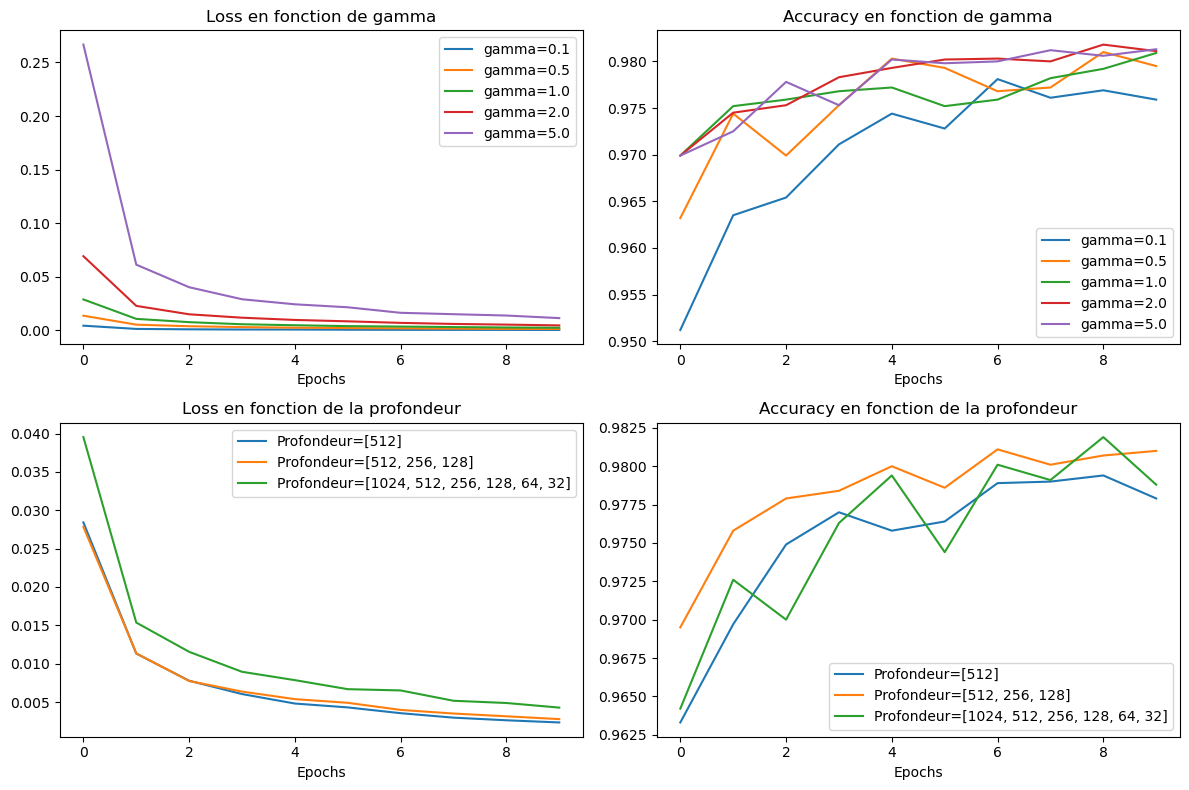

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Chargement des données MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


def large_margin_loss(outputs, targets, gamma):
    """Implémentation de la fonction de perte Large Margin Loss"""
    batch_size = outputs.shape[0]

    # Extraction des scores des classes correctes
    correct_class_scores = outputs.gather(1, targets.view(-1, 1))  # Shape [batch_size, 1]

    # Calcul des marges
    margins = gamma + (outputs - correct_class_scores)

    # Appliquer ReLU sans modification in-place
    margins = torch.relu(margins)

    # Mettre les marges des classes correctes à zéro sans modification in-place
    mask = torch.zeros_like(margins).scatter(1, targets.view(-1, 1), 1)
    margins = margins * (1 - mask)

    return margins.mean()


# Définition du réseau de neurones avec BatchNorm
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super().__init__()
        layers = [nn.Flatten()]  # Transformation des images 28x28 en un vecteur 784
        prev_dim = input_dim

        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))  # Normalisation de lot
            layers.append(nn.ReLU())
            prev_dim = h

        layers.append(nn.Linear(prev_dim, 10))  # 10 classes pour MNIST
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# Fonction d'entraînement et d'évaluation
def train_and_evaluate(hidden_layers, gamma, epochs=10, lr=0.001):
    model = NeuralNet(input_dim=28 * 28, hidden_layers=hidden_layers)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_values, acc_values = [], []
    criterion = lambda outputs, targets: large_margin_loss(outputs, targets, gamma)

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        # Évaluation sur les données de test
        model.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)

        test_acc = correct / total
        loss_values.append(train_loss)
        acc_values.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Test Accuracy: {test_acc:.4f}")

    return loss_values, acc_values


# Expérience 1 : Influence de gamma
gamma_values = [0.1, 0.5, 1.0, 2.0, 5.0]
losses_gamma, accs_gamma = {}, {}

for gamma in gamma_values:
    print(f"\n--- Entraînement avec gamma = {gamma} ---")
    loss, acc = train_and_evaluate(hidden_layers=[256, 128], gamma=gamma)
    losses_gamma[gamma] = loss
    accs_gamma[gamma] = acc


# Expérience 2 : Influence de la profondeur du réseau
depths = [[512], [512, 256, 128], [1024, 512, 256, 128, 64, 32]]
losses_depth, accs_depth = {}, {}

for depth in depths:
    print(f"\n--- Entraînement avec profondeur = {depth} ---")
    loss, acc = train_and_evaluate(hidden_layers=depth, gamma=1.0)
    losses_depth[str(depth)] = loss
    accs_depth[str(depth)] = acc


# Affichage des résultats
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Graphique : Influence de gamma
for gamma in gamma_values:
    axes[0, 0].plot(losses_gamma[gamma], label=f"gamma={gamma}")
    axes[0, 1].plot(accs_gamma[gamma], label=f"gamma={gamma}")

axes[0, 0].set_title("Loss en fonction de gamma")
axes[0, 1].set_title("Accuracy en fonction de gamma")

# Graphique : Influence de la profondeur
for depth in depths:
    axes[1, 0].plot(losses_depth[str(depth)], label=f"Profondeur={depth}")
    axes[1, 1].plot(accs_depth[str(depth)], label=f"Profondeur={depth}")

axes[1, 0].set_title("Loss en fonction de la profondeur")
axes[1, 1].set_title("Accuracy en fonction de la profondeur")

# Légendes et affichage
for ax in axes.flat:
    ax.legend()
    ax.set_xlabel("Epochs")

plt.tight_layout()
plt.show()

### 3.2 Analyse des résultats expérimentaux

**Influence de $\gamma$**

- Loss :  
  - pour des valeurs plus élevées de gamma (comme $5.0$), la perte initiale est plus importante mais diminue rapidement ;
  - les petites valeurs de gamma ($0.1$, $0.5$) commencent avec une perte plus faible et convergent rapidement vers des valeurs similaires.  

- Accuracy :  
  - l’exactitude s’améliore globalement pour toutes les valeurs de $\gamma$ ;
  - les valeurs $\gamma=1.0$ et $\gamma=2.0$ semblent donner les meilleures performances finales ;
  - un $\gamma$ trop élevé ($5.0$) introduit une plus grande instabilité en début d’apprentissage.  
 
Un $\gamma$ trop faible ($<1$) peut ne pas assez contraindre les marges, tandis qu’un $\gamma$ trop grand ($>2$) ralentit l’apprentissage initial. Un compromis semble exister autour de $\gamma=1.0$ ou $\gamma=2.0$.  

**Influence de la profondeur du réseau**

- Loss :  
  - les réseaux plus profonds ont une perte plus faible en fin d’entraînement ;
  - le réseau le plus profond (`[1024, 512, 256, 128, 64, 32]`) commence avec une perte plus élevée mais converge bien.  

- Accuracy :  
  - les réseaux plus profonds atteignent de meilleures performances plus rapidement ;
  - le réseau le plus profond (`[1024, 512, 256, 128, 64, 32]`) montre des oscillations, suggérant un possible sur-ajustement.  

Ajouter plus de couches améliore l’apprentissage, mais un compromis est nécessaire. Le réseau `[512, 256, 128]` semble être le meilleur équilibre entre stabilité et performance.

## 4. Applications et Extensions

### 4.1 Applications pratiques

Cette approche de la *Large Margin Loss* a démontré des gains significatifs dans plusieurs domaines :  

- Classification avec données déséquilibrées  
  - Dans de nombreuses applications, certaines classes sont largement sous-représentées, ce qui complique l’apprentissage et peut entraîner un biais du modèle en faveur des classes majoritaires.
  - La *Large Margin Loss* permet de renforcer la séparation entre les classes, en particulier pour les exemples difficiles ou minoritaires, contribuant ainsi à une meilleure performance globale (Liu et al., 2016).  

- **Reconnaissance faciale et biométrie**  
  - La reconnaissance faciale repose sur une bonne séparation des représentations des différentes identités. Les méthodes utilisant des marges larges, comme *CosFace* (Wang et al., 2018) et *ArcFace* (Deng et al., 2019), ont significativement amélioré la discrimination entre classes en renforçant la contrainte de séparation angulaire.  
  - Ces avancées sont cruciales pour des applications telles que la sécurité biométrique et l’authentification d’identité.  

- Apprentissage profond en NLP et en vision par ordinateur  
  - En traitement du langage naturel (NLP), la *Large Margin Loss* a été explorée dans des architectures de transformers pour améliorer la robustesse des représentations (Zhang et al., 2020).  
  - En vision par ordinateur, elle est particulièrement efficace pour les tâches où des objets de différentes classes présentent des similarités structurelles (ex. classification fine-grainée d’images médicales ou de véhicules).  

- Apprentissage robuste aux perturbations et aux attaques adversariales  
  - Une plus grande marge de séparation améliore la résistance du modèle face aux exemples bruités ou adversariaux (Madry et al., 2018).  
  - Dans ce cadre, la *Large Margin Loss* est étudiée pour améliorer la robustesse des modèles de deep learning certifiables, notamment dans les applications critiques comme la santé et la conduite autonome.  

### 4.2 Extensions et pistes de recherche
L’efficacité de la Large Margin Loss a conduit à de nombreuses pistes d’amélioration et d’extensions potentielles, parmi lesquelles :  

- Extension aux architectures avancées  
  - Son intégration dans les réseaux convolutionnels profonds (CNNs) et transformers pourrait permettre de mieux contrôler la discrimination inter-classes.  
  - Son application dans les réseaux génératifs adversariaux (GANs) est également explorée pour stabiliser l’entraînement et améliorer la qualité des échantillons générés (Miyato et al., 2018).  

- *Large Margin Loss* et apprentissage auto-supervisé  
  - L’apprentissage auto-supervisé repose sur la capacité du réseau à extraire des représentations discriminatives sans supervision explicite.  
  - L’ajout d’une contrainte de marge dans ces méthodes pourrait améliorer la séparation entre clusters de représentations, notamment dans des approches contrastives comme *SimCLR* ou *BYOL* (Chen et al., 2020).  

- Optimisation adaptative et contrôle de la marge  
  - Une question ouverte concerne le choix du coefficient de marge optimal.  
  - Des stratégies adaptatives utilisant des algorithmes d’optimisation avancés, comme *AdaMargin* (Zhang et al., 2021), pourraient améliorer la convergence et la généralisation.  

- Applications aux données non structurées et non étiquetées  
  - L'extension de cette approche aux données non supervisées, notamment via l’intégration avec des méthodes de clustering, ouvre des perspectives intéressantes pour la reconnaissance d’anomalies et l’apprentissage représentatif.  

### 4.3 Défis et limites
Malgré ses atouts, la Large Margin Loss présente encore plusieurs défis scientifiques et pratiques :  

- Choix du paramètre de marge : La sélection optimale de la marge $\gamma$ reste un défi et peut nécessiter une validation coûteuse.  
- Complexité computationnelle : La régularisation par marge peut augmenter la difficulté d’entraînement, notamment sur des réseaux profonds et des datasets massifs (comme *ImageNet*).  
- Généralisation hors distribution : L’impact de la *Large Margin Loss* sur la capacité du modèle à généraliser à des distributions de données inconnues reste un sujet d’étude en cours.


## 5. **Conclusion**

### 5.1 Synthèse des points clés
L’introduction d’une *Large Margin Loss* constitue une avancée significative dans l’amélioration des performances des réseaux neuronaux en classification.  
Ses principaux avantages incluent :  
- Une meilleure séparation des classes, en particulier dans les scénarios déséquilibrés.  
- Une robustesse accrue face aux exemples difficiles ou bruités.  
- Une résilience améliorée aux attaques adversariales en apprentissage robuste.  

Les recherches récentes ont démontré que cette approche peut être appliquée avec succès à des architectures variées, allant des *CNNs* aux Transformers, et qu’elle présente un fort potentiel dans les domaines du NLP, de la vision et de la reconnaissance biométrique.  

### 5.2 Perspectives de recherche et de développement
Plusieurs directions de recherche restent à explorer :  
- Affiner les stratégies d’optimisation** pour adapter dynamiquement la marge aux caractéristiques des données ;
- Explorer l’intégration avec des architectures avancées** comme les modèles auto-supervisés et les GANs ;
- Évaluer son impact sur des modèles massifs** (GPT, ViT) et des données non supervisées.  

À long terme, la *Large Margin Loss* pourrait devenir une composante standard des modèles de classification, en particulier dans des environnements où la robustesse et la généralisation sont critiques.  


### Références  
- Bartlett, P. L. et al. (2017). *Spectrally-normalized margin bounds for neural networks*. NeurIPS.  
- Goodfellow, I. et al. (2015). *Explaining and Harnessing Adversarial Examples*. ICLR.  
- Liu, W. et al. (2016). *Large-margin softmax loss for CNNs*. ICML.  
- Neyshabur, B. et al. (2018). *Understanding the Role of Over-Parametrization in Generalization of Neural Networks*. ICLR.  
- Schroff, F. et al. (2015). *FaceNet: A Unified Embedding for Face Recognition*. CVPR.  
- Sokolic, J. et al. (2017). *Robust Large Margin Deep Neural Networks*. IEEE TSP.  
- Vapnik, V. (1995). *The Nature of Statistical Learning Theory*. Springer.  
- Schölkopf, B. et al. (1997). *Kernel principal component analysis*. NeurIPS.  
- Wang, H. et al. (2018). *CosFace: Large Margin Cosine Loss for Deep Face Recognition*. CVPR.  
- Deng, J. et al. (2019). *ArcFace: Additive Angular Margin Loss for Deep Face Recognition*. CVPR.  
- Madry, A. et al. (2018). *Towards Deep Learning Models Resistant to Adversarial Attacks*. ICLR.  
- Miyato, T. et al. (2018). *Spectral Normalization for Generative Adversarial Networks*. ICLR.  
- Zhang, H. et al. (2020). *Self-supervised Contrastive Learning with Large Margin Loss*. NeurIPS.  
- Chen, T. et al. (2020). *A Simple Framework for Contrastive Learning of Visual Representations*. ICML.  
- Zhang, X. et al. (2021). *AdaMargin: Adaptive Margin Learning for Deep Neural Networks*. NeurIPS.  